# Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nolitsa.nolitsa import data
from STPDP import STPDP
from SSRPC import SSRPC

# Generate data

In [2]:
sample = 0.01  # sampling period
x0 = [0.62225717, -0.08232857, 30.60845379]  # initial condition

# generate Lorenz system data
lorenz_x = data.lorenz(length=1000 + 15000, sample=sample, x0=x0, sigma=16.0, beta=4.0, rho=45.92)[1][:, 0]

# STPDP demo

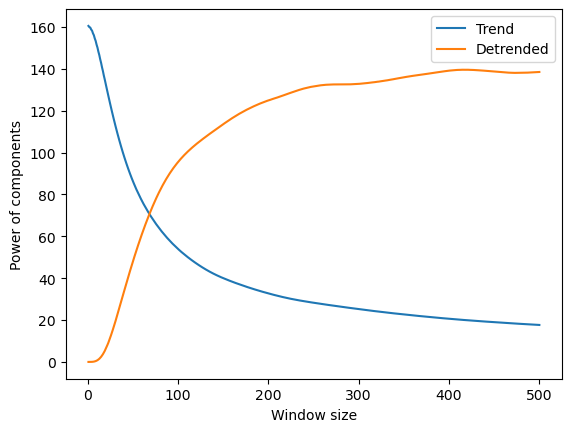

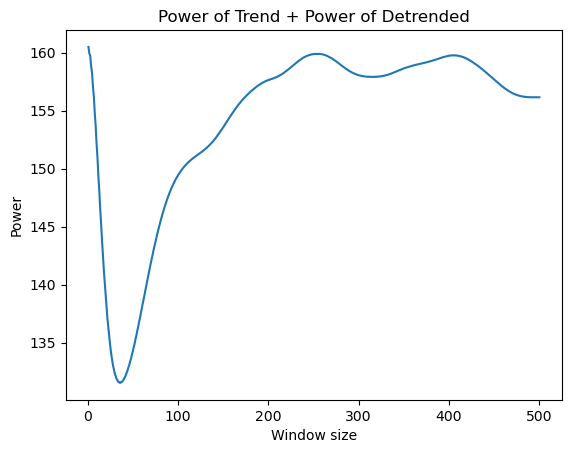

omega: 72


In [3]:
stpdp = STPDP(lorenz_x[1000:], max_length=500)  # transient section 이후의 데이터 사용
omega = stpdp.calculate_omega()
stpdp.plot()

# SSRPC demo

In [4]:
stpdp = STPDP(lorenz_x[1000:], max_length=500)  # transient section 이후의 데이터 사용
omega = stpdp.calculate_omega()
ssrpc = SSRPC(lorenz_x[1000:], sample, omega)
ssrpc.reconstruct()
ssrpc.calculate_divergence(maxt=500)

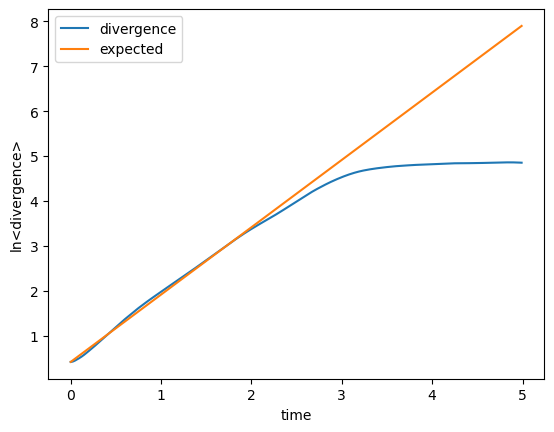

In [5]:
ssrpc.plot_divergence(expected=1.5)

In [6]:
mle = ssrpc.mle((0, 250))
print(mle)

1.454471474800469
